## Sensitivity Analysis for Linear Regression Models
Sensitivity analysis helps us examine how sensitive a result is against the possibility of unobserved confounding. The current method only supports linear regression estimator. <br>
The partial R^2 of treatment with outcome shows how strongly confounders explaining all the residual outcome variation would have to be associated with the treatment to eliminate the estimated effect.<br>
The robustness value measures the minimum strength of association unobserved confounding should have with both treatment and outcome in order to change the conclusions.<br>
Robustness value close to 1 means the treatment effect can handle strong confounders explaining  almost all residual variation of the treatment and the outcome.<br>
Robustness value close to 0 means that even very weak confounders can also change the results.<br>
Benchmarking examines the sensitivity of causal inferences to plausible strengths of the omitted confounders.<br>
This method is based on https://carloscinelli.com/files/Cinelli%20and%20Hazlett%20(2020)%20-%20Making%20Sense%20of%20Sensitivity.pdf 

### Step 1: Load required packages

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../../"))
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np
import dowhy.datasets 

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'ERROR',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning
#warnings.filterwarnings(action='ignore', category=DataConversionWarning)

### Step 2: Load the dataset 
We create a dataset with linear relationships between common causes and treatment, and common causes and outcome. Beta is the true causal effect.

In [2]:
np.random.seed(100) 
data = dowhy.datasets.linear_dataset( beta = 10,
                                      num_common_causes = 7,
                                      num_samples = 500,
                                      num_treatments = 1,
                                     stddev_treatment_noise =10,
                                     stddev_outcome_noise = 5
                                    )

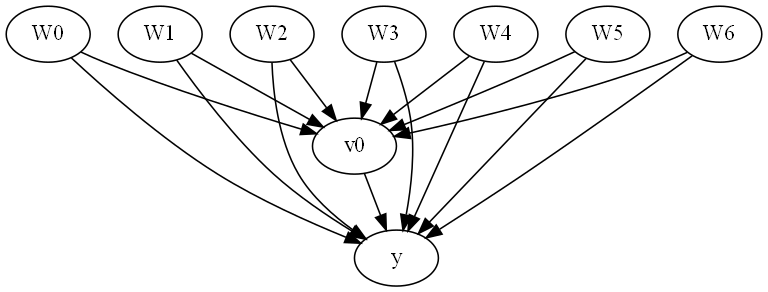

,W0,W1,W2,W3,W4,W5,W6,v0,y
0,-0.145062,-0.235286,0.784843,0.869131,-1.567724,-1.290234,0.116096,True,1.386517
1,-0.228109,-0.020264,-0.589792,0.188139,-2.649265,-1.764439,-0.167236,False,-16.159402
2,0.868298,-1.097642,-0.109792,0.487635,-1.861375,-0.527930,-0.066542,False,-0.702560
3,-0.017115,1.123918,0.346060,1.845425,0.848049,0.778865,0.596496,True,27.714465
4,-0.757347,-1.426205,-0.457063,1.528053,-2.681410,0.394312,-0.687839,False,-20.082633


In [3]:
model = CausalModel(
            data=data["df"],
            treatment=data["treatment_name"],
            outcome=data["outcome_name"],
            graph=data["gml_graph"],
            test_significance=None,
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))
data['df'].head()

### Step 3: Create Causal Model
Remove one of the common causes to simulate unobserved confounding

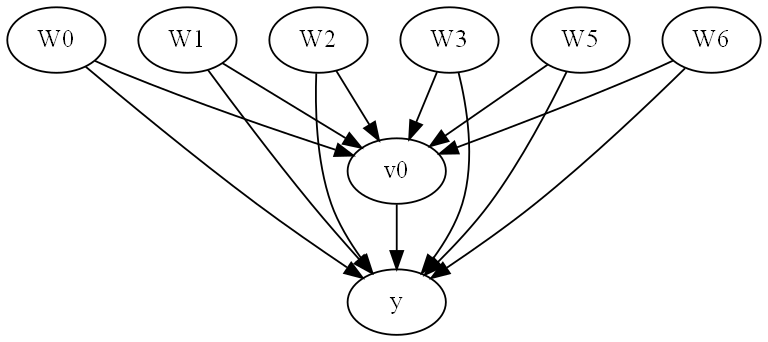

,W0,W1,W2,W3,W5,W6,v0,y
0,-0.145062,-0.235286,0.784843,0.869131,-1.290234,0.116096,True,1.386517
1,-0.228109,-0.020264,-0.589792,0.188139,-1.764439,-0.167236,False,-16.159402
2,0.868298,-1.097642,-0.109792,0.487635,-0.527930,-0.066542,False,-0.702560
3,-0.017115,1.123918,0.346060,1.845425,0.778865,0.596496,True,27.714465
4,-0.757347,-1.426205,-0.457063,1.528053,0.394312,-0.687839,False,-20.082633


In [4]:
data["df"] = data["df"].drop("W4", axis = 1)
graph_str = 'graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"]  node[ id "W5" label "W5"] node[ id "W6" label "W6"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W5" target "v0"] edge[ source "W6" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W5" target "y"] edge[ source "W6" target "y"]]'
model = CausalModel(
            data=data["df"],
            treatment=data["treatment_name"],
            outcome=data["outcome_name"],
            graph=graph_str,
            test_significance=None,
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))
data['df'].head()

### Step 4: Identification

In [5]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W5,W3,W6,W1,W2,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W5,W3,W6,W1,W2,W0,U) = P(y|v0,W5,W3,W6,W1,W2,W0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Step 5: Estimation
Currently only Linear Regression estimator is supported for Linear Sensitivity Analysis

In [6]:
estimate = model.estimate_effect(identified_estimand,method_name="backdoor.linear_regression")
print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W5,W3,W6,W1,W2,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W5,W3,W6,W1,W2,W0,U) = P(y|v0,W5,W3,W6,W1,W2,W0)

## Realized estimand
b: y~v0+W5+W3+W6+W1+W2+W0
Target units: ate

## Estimate
Mean value: 10.697677486880925



### Step 6: Refutation and Sensitivity Analysis
<b>identified_estimand</b>: An instance of the identifiedEstimand class that provides the information with respect to which causal pathways are employed when the treatment effects the outcome<br>
<b>estimate</b>: An instance of CausalEstimate class. The estimate obtained from the estimator for the original data.<br>
<b>method_name</b>: Refutation method name <br>
<b>simulated_method_name</b>: "PartialR2" for Linear Sensitivity Analysis<br>
<b>benchmark_covariates</b>: Name of the covariates used to bound the strengths of unobserved confounder<br>
<b>percent_change_rvalue</b>:Percentage of reduction on treatment coefficient that could turn out problematic <br>
<b>increase</b>: increase = True implies that confounder increases the absolute value of estimate and vice versa. Default is increase = False i.e. the considered confounders pull estimate towards zero<br>
<b>effect_fraction_on_treatment</b>: Strength of association between benchmark and treatment variable to test with benchmark bounding<br>
<b>effect_fraction_on_outcome</b>: Strength of association between benchmark and outcome variable to test with benchmark bounding<br>


Bad key "text.kerning_factor" on line 4 in
C:\Users\anush\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


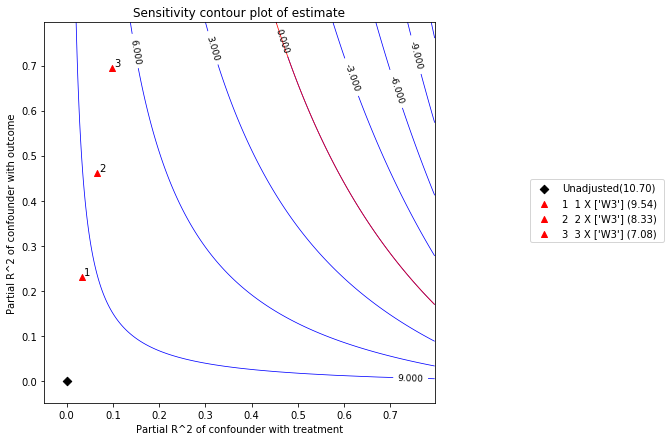

In [7]:
refute = model.refute_estimate(identified_estimand, estimate ,
                               method_name = "add_unobserved_common_cause",
                               simulated_method_name = "PartialR2", 
                               benchmark_covariates = ["W3"],
                               effect_fraction_on_treatment = [ 1,2,3])

The horizontal axis shows hypothetical values of the partial R2 of unobserved confounder(s) with the treatment. The vertical axis shows hypothetical values of the partial R2 of unobserved confounder(s) with the outcome.<br>
The contour levels represent adjusted t-values or estimates for unobserved confounders with hypothetical partialR2 values when these would be included in full regression model. <br>
The red line is the critical threshold: confounders with such strength or stronger are sufficient to invalidate the research conclusions.

In [8]:
refute.stats

{'estimate': 10.697677486880925,
 'standard_error': 0.5938735661282951,
 'degree of freedom': 492,
 't_statistic': 18.01339223872762,
 'r2yt_w': 0.3974149837266681,
 'partial_f2': 0.6595168698094561,
 'robustness_value': 0.5467445572181009,
 'robustness_value_alpha': 0.5076289101030926}

In [9]:
refute.benchmarking_results

,r2tu_w,r2yu_tw,bias_adjusted_estimate,bias_adjusted_se,bias_adjusted_t,bias_adjusted_lower_CI,bias_adjusted_upper_CI
0,0.032677,0.230238,9.535964,0.530308,17.981928,8.494016,10.577912
1,0.065354,0.461490,8.331381,0.451241,18.463243,7.444783,9.217979
2,0.098031,0.693855,7.080284,0.346341,20.443123,6.399795,7.760773


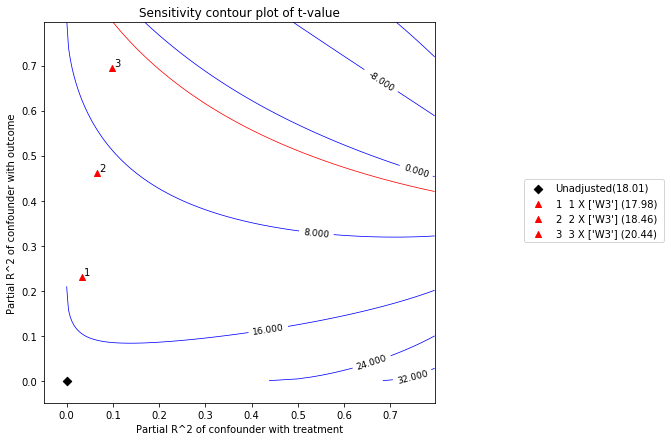

In [10]:
refute.plot(sensitivity_variable = 't-value')

The t statistic is the coefficient divided by its standard error. The higher the t-value, the greater the evidence to reject the null hypothesis. <br>
The plot of t-value reveals that at 5% significance level, the null hypothesis of zero effect would be rejected given the above confounders. 

In [11]:
print(refute)

Sensitivity Analysis to Unobserved Confounding using R^2 paramterization

Unadjusted Estimates of Treatment ['v0'] :
Coefficient Estimate : 10.697677486880925
Degree of Freedom : 492
Standard Error : 0.5938735661282951
t-value : 18.01339223872762
F^2 value : 0.6595168698094561

Sensitivity Statistics : 
Partial R2 of treatment with outcome : 0.3974149837266681
Robustness Value : 0.5467445572181009

Interpretation of results :
Any confounder explaining less than 54.67% percent of the residual variance of both the treatment and the outcome would not be strong enough to explain away the observed effect i.e bring down the estimate to 0 

For a significance level of 5.0%, any confounder explaining more than 50.76% percent of the residual variance of both the treatment and the outcome would be strong enough to make the estimated effect not 'statistically significant'

If confounders explained 100% of the residual variance of the outcome, they would need to explain at least 39.74% of the resi

In [12]:
np.random.seed(100) 
data = dowhy.datasets.linear_dataset( beta = 10,
                                      num_common_causes = 7,
                                      num_samples = 500,
                                      num_treatments = 1,
                                     stddev_treatment_noise=10,
                                     stddev_outcome_noise = 1
                                    )

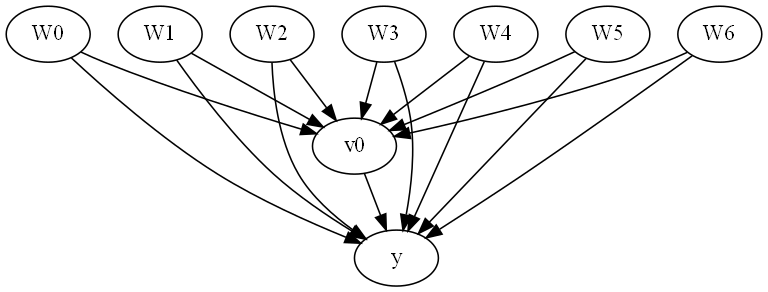

,W0,W1,W2,W3,W4,W5,W6,v0,y
0,-0.145062,-0.235286,0.784843,0.869131,-1.567724,-1.290234,0.116096,True,6.311809
1,-0.228109,-0.020264,-0.589792,0.188139,-2.649265,-1.764439,-0.167236,False,-12.274406
2,0.868298,-1.097642,-0.109792,0.487635,-1.861375,-0.527930,-0.066542,False,-6.487561
3,-0.017115,1.123918,0.346060,1.845425,0.848049,0.778865,0.596496,True,24.653183
4,-0.757347,-1.426205,-0.457063,1.528053,-2.681410,0.394312,-0.687839,False,-13.770396


In [13]:
model = CausalModel(
            data=data["df"],
            treatment=data["treatment_name"],
            outcome=data["outcome_name"],
            graph=data["gml_graph"],
            test_significance=None,
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))
data['df'].head()

In [14]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W5,W3,W6,W4,W1,W2,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W5,W3,W6,W4,W1,W2,W0,U) = P(y|v0,W5,W3,W6,W4,W1,W2,W0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [15]:
estimate = model.estimate_effect(identified_estimand,method_name="backdoor.linear_regression")
print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W5,W3,W6,W4,W1,W2,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W5,W3,W6,W4,W1,W2,W0,U) = P(y|v0,W5,W3,W6,W4,W1,W2,W0)

## Realized estimand
b: y~v0+W5+W3+W6+W4+W1+W2+W0
Target units: ate

## Estimate
Mean value: 10.08192437558831



C:\Users\anush\msr\dowhy\dowhy\causal_refuters\linear_sensitivity_analysis.py:183: RuntimeWarning: divide by zero encountered in true_divide
  bias_adjusted_t = (bias_adjusted_estimate - self.h0) / bias_adjusted_se
C:\Users\anush\msr\dowhy\dowhy\causal_refuters\linear_sensitivity_analysis.py:185: RuntimeWarning: invalid value encountered in true_divide
  bias_adjusted_partial_r2 = bias_adjusted_t ** 2 / (bias_adjusted_t ** 2 + (self.degree_of_freedom - 1)) #partial r2 formula used with new t value and dof - 1
C:\Users\anush\msr\dowhy\dowhy\causal_refuters\linear_sensitivity_analysis.py:389: UserWarning: No contour levels were found within the data range.
  contour_plot = ax.contour(r2tu_w, r2yu_tw, contour_values, colors = threshold_color, linewidths = 0.75, levels = [contour_threshold])


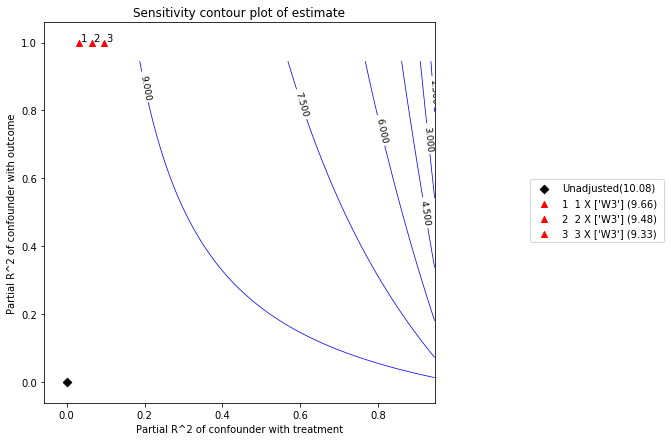

In [16]:
refute = model.refute_estimate(identified_estimand, estimate ,
                               method_name = "add_unobserved_common_cause",
                               simulated_method_name = "PartialR2", 
                               benchmark_covariates = ["W3"],
                               effect_fraction_on_treatment = [ 1,2,3])

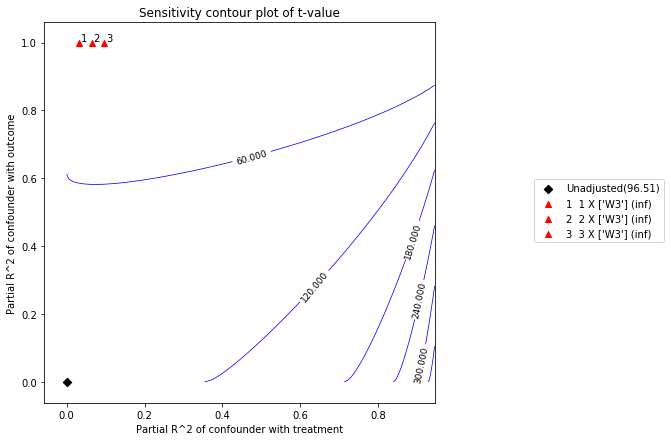

In [17]:
refute.plot(sensitivity_variable = 't-value')

In [18]:
print(refute)

Sensitivity Analysis to Unobserved Confounding using R^2 paramterization

Unadjusted Estimates of Treatment ['v0'] :
Coefficient Estimate : 10.081924375588308
Degree of Freedom : 491
Standard Error : 0.10446229543424754
t-value : 96.51256784735548
F^2 value : 18.970826379817506

Sensitivity Statistics : 
Partial R2 of treatment with outcome : 0.9499269594066173
Robustness Value : 0.9522057801012398

Interpretation of results :
Any confounder explaining less than 95.22% percent of the residual variance of both the treatment and the outcome would not be strong enough to explain away the observed effect i.e bring down the estimate to 0 

For a significance level of 5.0%, any confounder explaining more than 95.04% percent of the residual variance of both the treatment and the outcome would be strong enough to make the estimated effect not 'statistically significant'

If confounders explained 100% of the residual variance of the outcome, they would need to explain at least 94.99% of the res

In [19]:
refute.stats

{'estimate': 10.081924375588308,
 'standard_error': 0.10446229543424754,
 'degree of freedom': 491,
 't_statistic': 96.51256784735548,
 'r2yt_w': 0.9499269594066173,
 'partial_f2': 18.970826379817506,
 'robustness_value': 0.9522057801012398,
 'robustness_value_alpha': 0.950386691319526}

In [20]:
refute.benchmarking_results

,r2tu_w,r2yu_tw,bias_adjusted_estimate,bias_adjusted_se,bias_adjusted_t,bias_adjusted_lower_CI,bias_adjusted_upper_CI
0,0.031976,1.0,9.661229,0.0,inf,9.661229,9.661229
1,0.063952,1.0,9.476895,0.0,inf,9.476895,9.476895
2,0.095927,1.0,9.327927,0.0,inf,9.327927,9.327927
